In [1]:

import matplotlib.pyplot as plt 
import numpy as np
from scipy.io import wavfile
from numpy.fft import fft, ifft
import scipy.signal as sig


# model_deployment

external dependencies:
* ./audiolibrary.json
* ./footprints.json
* ./predictionclasses.csv

# loading the definition of the samples and footprints (engineered features)

11 samples taken from two separate online archives - one for training purposes and one for testing
* https://theremin.music.uiowa.edu/MIS-Pitches-2012/ - for training (6 samples)
* https://freesound.org - for testing (5 samples)

In [2]:
import json
with open('audiolibrary.json') as audiolibrary_file:
    library = json.load(audiolibrary_file)
    
print('library loaded with',len(library),'items')

library loaded with 18 items


In [3]:
def check_uniqueness_of_library_field(library,field):
    labels = [ dd[field] for dd in library]
    print(len(labels),field)
    return len(labels) == len(set(labels))

In [4]:
assert check_uniqueness_of_library_field(library,'label')
assert check_uniqueness_of_library_field(library,'wav')

18 label
18 wav


In [5]:
import json
with open('footprints.json') as footprints_file:
    footprints = json.load(footprints_file)
    
print('footprints loaded with',len(footprints),'items')

footprints loaded with 18 items


In [6]:
import pandas as pd

## load istm-dummy mapping for prediction models (M)

In [7]:
dfm= pd.read_csv('predictionclasses.csv') # ,index_col='class')
assert dfm.columns.tolist() == 'istm,class,classn'.split(',')
dfm

,istm,class,classn
0,Bassoon,0,0.0
1,Viola,1,1.0
2,Cello,2,2.0
3,FrHorn,3,3.0
4,Flute,4,4.0
5,Clarinet,5,5.0


## loading the footprints (each with custom pairs of freq/magnitude) in a dataframe

In [8]:

dfu = None
for fp in footprints:
    NR = len(fp['pkf'])
    #print(fp['label'],fp['train'],'NR',NR)
    #print(NR,fp['pkf'],fp['pkm'])
    df = pd.DataFrame({
        'label':[fp['label']]*NR,
        'train':[fp['train']]*NR,
        'istm':[fp['istm']]*NR,
        'note':[fp['note']]*NR,
        'freq':fp['pkf'],
        'magn':fp['pkm']
    })
    if dfu is None:
        dfu = df
    else:
        dfu = pd.concat([dfu,df],ignore_index=True)

In [9]:
dfu.head()

,label,train,istm,note,freq,magn
0,Bassoon1a,1,Bassoon,A3,440.000000,1.000000
1,Bassoon1a,1,Bassoon,A3,881.981982,10.699971
2,Bassoon1a,1,Bassoon,A3,1321.981982,0.798439
3,Bassoon1a,1,Bassoon,A3,1763.963964,1.161748
4,Bassoon1a,1,Bassoon,A3,2203.963964,0.419192


In [10]:
dfu = dfu.join(dfm.set_index('istm'),on='istm')
dfu.head()

,label,train,istm,note,freq,magn,class,classn
0,Bassoon1a,1,Bassoon,A3,440.000000,1.000000,0,0.0
1,Bassoon1a,1,Bassoon,A3,881.981982,10.699971,0,0.0
2,Bassoon1a,1,Bassoon,A3,1321.981982,0.798439,0,0.0
3,Bassoon1a,1,Bassoon,A3,1763.963964,1.161748,0,0.0
4,Bassoon1a,1,Bassoon,A3,2203.963964,0.419192,0,0.0


### stats on peaks for each footprint

In [11]:
dfu.groupby('label')['freq'].agg(['min', 'max', 'count'])

,min,max,count
label,,,
Bassoon1a,440.0,8377.837838,17
Bassoon2a,440.0,2200.000000,5
Bassoon3a_x,440.0,4842.211055,11
Cello1a,440.0,7942.000000,17
Cello2a,440.0,9222.983425,18
Cello3a_x,440.0,9346.944444,19
Clarinet1a,440.0,5284.000000,11
Clarinet2a,440.0,2190.638298,4
Clarinet3a_x,440.0,8345.729730,18


In [12]:
samples = dfu[['label','train','istm','note']].drop_duplicates()
samples

,label,train,istm,note
0,Bassoon1a,1,Bassoon,A3
17,Bassoon2a,1,Bassoon,A4
22,Bassoon3a_x,0,Bassoon,G3
33,Viola1a,1,Viola,A3
48,Viola2a,1,Viola,G3
61,Viola3a_x,0,Viola,G4
64,Cello1a,1,Cello,A2
81,Cello2a,1,Cello,F3
99,Cello3a_x,0,Cello,D3
118,FrHorn1a,1,FrHorn,A4


In [13]:
pd.crosstab(index=samples.istm,columns=samples.train,values=samples.label,aggfunc='count')

train,0,1
istm,,
Bassoon,1,2
Cello,1,2
Clarinet,1,2
Flute,1,2
FrHorn,1,2
Viola,1,2


In [14]:
# round the frequencies
dfu['freq'] = round(dfu['freq'],2)

# approach 1 - merge all
### CORR_ON_LININTERP_MERGED_PEAKFREQS

* take the union of all the freqs of the datapoints of all the samples
* interpolate
* now you have a PANEL DATA
* compute the correlations of the interpolated-paneled footprints
* reploy to classification requests using the correlation matrix

In [15]:
# using dfu

In [16]:
ctab = pd.crosstab(index = [dfu.freq], columns = dfu.label, values=dfu.magn, aggfunc='max')#.unstack()
# max function: thanks to the previous assertion, we are sure that max *is* the ONLY value itself.
ctab.head()
# https://stackoverflow.com/questions/46829769/pandas-dataframe-flatten-crosstab-with-multilevel-index ...?

label,Bassoon1a,Bassoon2a,Bassoon3a_x,Cello1a,Cello2a,Cello3a_x,Clarinet1a,Clarinet2a,Clarinet3a_x,Flute1a,Flute2a,Flute3a_x,FrHorn1a,FrHorn2a,FrHorn3a_x,Viola1a,Viola2a,Viola3a_x
freq,,,,,,,,,,,,,,,,,,
440.00,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
873.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.953322,NaN,NaN,NaN,NaN,NaN,NaN,NaN
876.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.268549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
877.57,NaN,NaN,NaN,NaN,0.216723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
878.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.179289,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
ctab_intrp = ctab.interpolate(method='slinear') # linear, quadratic, cubic...
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate
ctab_intrp.head()

label,Bassoon1a,Bassoon2a,Bassoon3a_x,Cello1a,Cello2a,Cello3a_x,Clarinet1a,Clarinet2a,Clarinet3a_x,Flute1a,Flute2a,Flute3a_x,FrHorn1a,FrHorn2a,FrHorn3a_x,Viola1a,Viola2a,Viola3a_x
freq,,,,,,,,,,,,,,,,,,
440.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
873.28,10.509035,0.955160,1.282774,0.719496,0.224402,3.209029,0.270081,0.274576,0.054055,1.540813,0.953322,7.103363,0.452625,1.296627,1.728135,0.756879,6.715393,0.608748
876.88,10.588043,0.954788,1.285124,0.717165,0.217958,3.227383,0.264017,0.268549,0.046196,1.545307,0.947910,7.154074,0.448077,1.299091,1.734185,0.754859,6.762881,0.605498
877.57,10.603186,0.954716,1.285574,0.716718,0.216723,3.230901,0.262854,0.268687,0.044689,1.546168,0.946873,7.163793,0.447206,1.299564,1.735344,0.754472,6.771983,0.604875
878.67,10.627328,0.954602,1.286292,0.716006,0.216475,3.236509,0.261001,0.268908,0.042288,1.547541,0.945219,7.179289,0.445816,1.300317,1.737193,0.753855,6.786493,0.603881


In [18]:
del ctab

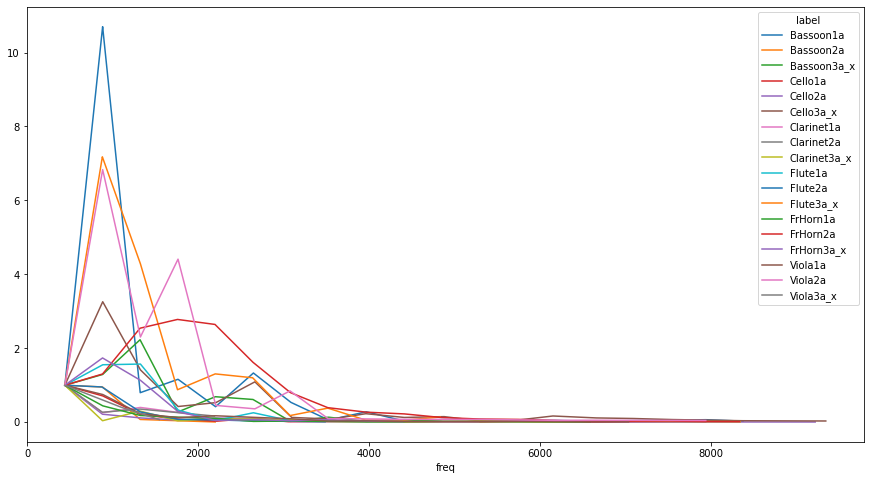

In [19]:
ax = ctab_intrp.plot(figsize=(15, 8))

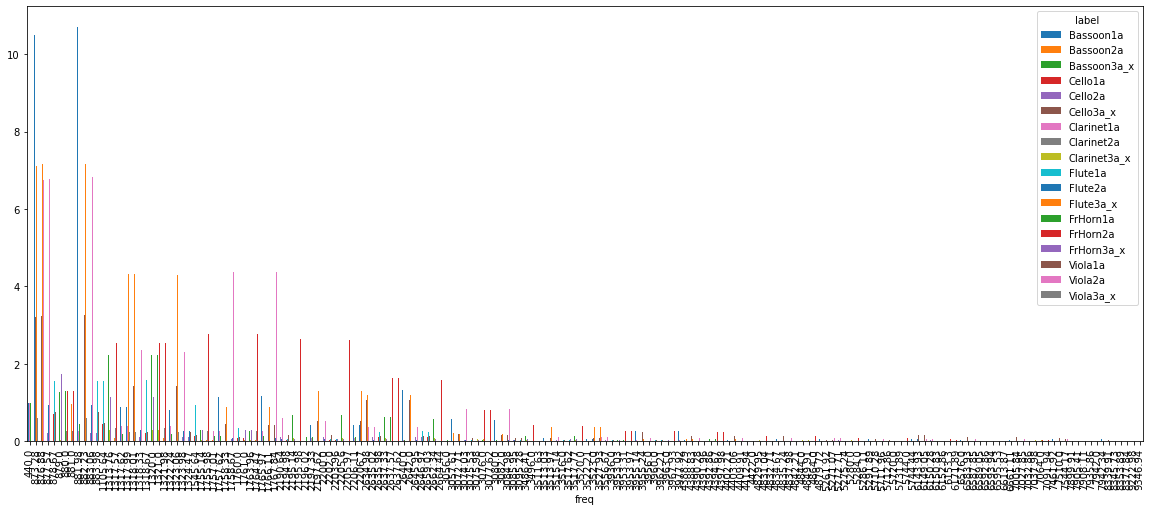

In [20]:
ax = ctab_intrp.plot.bar(figsize=(20, 8))

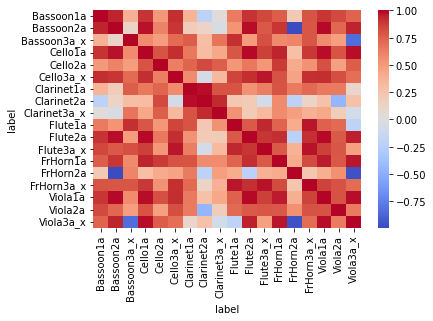

In [21]:
import seaborn as sns
corr = ctab_intrp.corr()
ax = sns.heatmap(corr,cmap="coolwarm")

In [22]:
def get_the_samples_to_test(dfu):
    dfut = dfu[['label','train']].drop_duplicates().set_index('label')
    totest = dfut.query('train==0').index.tolist()
    return totest

In [23]:
def get_the_best_corrbased_match1(corr,dfu,testlabel1):
    dfut = dfu[['label','train','istm']].drop_duplicates().set_index('label')
    corr_w_trainflag = corr.join(dfut)
    candidates = corr_w_trainflag.query("train==1")[testlabel1]
    return { 'q': testlabel1, 'a': candidates.idxmax(), 'corr': candidates.max() }

In [24]:
def get_the_best_corrbased_matches(corr,dfu):
    dfa = pd.DataFrame({'q':[],'a':[],'corr':[]})
    totest = get_the_samples_to_test(dfu)
    for testlabel in totest:
        dfa.loc[len(dfa)] = get_the_best_corrbased_match1(corr,dfu,testlabel)
    return dfa

In [25]:
dfco = get_the_best_corrbased_matches(corr,dfu)
dfco

,q,a,corr
0,Bassoon3a_x,Flute1a,0.909310
1,Viola3a_x,Cello1a,0.983810
2,Cello3a_x,Viola1a,0.919549
3,FrHorn3a_x,Flute1a,0.962820
4,Flute3a_x,Flute1a,0.930254
5,Clarinet3a_x,Clarinet2a,0.924670


In [26]:
df2export = dfco.join(
                dfu[['label','class']].drop_duplicates().set_index('label'), # label, class
                on='a')[['q','class']].rename(columns={
                    'q':'test_sample','class':'predicted_class'
                })
df2export

,test_sample,predicted_class
0,Bassoon3a_x,4
1,Viola3a_x,2
2,Cello3a_x,1
3,FrHorn3a_x,4
4,Flute3a_x,4
5,Clarinet3a_x,5


In [27]:
df2export.reset_index(drop=True).to_csv('modelprediction.CORR_ON_LININTERP_MERGED_PEAKFREQS.1.csv')

In [28]:
del corr
del ctab_intrp

# approach 2

### MAE_ON_MEAN_ROUNDED_PEAKFREQS

In [29]:
# using: dfu

In [30]:
# create rounded frequencies
dfu['rfreq'] = round(440. * round(dfu['freq'] / 440.),1)

In [31]:
ctab_rnd = pd.crosstab(index = dfu.rfreq, columns = dfu.label, values=dfu.magn, aggfunc='mean')
ctab_rnd.head()
# https://stackoverflow.com/questions/46829769/pandas-dataframe-flatten-crosstab-with-multilevel-index ...?

label,Bassoon1a,Bassoon2a,Bassoon3a_x,Cello1a,Cello2a,Cello3a_x,Clarinet1a,Clarinet2a,Clarinet3a_x,Flute1a,Flute2a,Flute3a_x,FrHorn1a,FrHorn2a,FrHorn3a_x,Viola1a,Viola2a,Viola3a_x
rfreq,,,,,,,,,,,,,,,,,,
440.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
880.0,10.699971,0.954465,1.287160,0.715145,0.216723,3.258891,0.257076,0.268549,0.039384,1.554169,0.953322,7.179289,0.445399,1.301227,1.739428,0.753108,6.833453,NaN
1320.0,0.798439,0.074218,2.230427,0.209307,0.117438,1.418060,0.400087,0.356209,0.303004,1.574167,0.278414,4.329142,0.181920,2.541780,1.145212,0.230039,2.305600,0.398928
1760.0,1.161748,0.041790,0.274885,0.083307,0.054024,0.424709,0.266510,NaN,0.036932,0.327422,0.077146,0.878266,0.136665,2.780772,0.294795,0.123320,4.410869,0.070949
2200.0,0.419192,0.006516,0.689737,0.025070,0.112100,0.528485,0.090443,0.167185,0.090113,0.046026,0.062842,1.307342,0.106966,2.647956,0.049579,0.174445,0.453623,NaN


In [32]:
def mse(actual, pred): 
    #actual, pred = np.array(actual), np.array(pred)
    
    MAE = True
    MSE = False
    logMSE = False
    logMAE = False
    if MSE: return np.square(np.subtract(actual,pred)).mean()
    if MAE: return np.abs(   np.subtract(actual, pred)).mean()
    if logMSE: return np.square(np.subtract(np.log(actual),np.log(pred))).mean()
    if logMAE: return np.abs(   np.subtract(np.log(actual), np.log(pred))).mean()


In [33]:
#from sklearn.metrics import mean_squared_error
#predicted =y_pred.as_matrix()
#actual= y_true.as_matrix()
#mean_squared_error(actual, predicted)

In [34]:
dfum = dfu.join(dfm.set_index('istm'),on='istm',rsuffix='_map')
dfum.head()

,label,train,istm,note,freq,magn,class,classn,rfreq,class_map,classn_map
0,Bassoon1a,1,Bassoon,A3,440.00,1.000000,0,0.0,440.0,0,0.0
1,Bassoon1a,1,Bassoon,A3,881.98,10.699971,0,0.0,880.0,0,0.0
2,Bassoon1a,1,Bassoon,A3,1321.98,0.798439,0,0.0,1320.0,0,0.0
3,Bassoon1a,1,Bassoon,A3,1763.96,1.161748,0,0.0,1760.0,0,0.0
4,Bassoon1a,1,Bassoon,A3,2203.96,0.419192,0,0.0,2200.0,0,0.0


In [35]:
def get_ct_mse(ct):

    dfe = pd.DataFrame({'test':[],'train':[],'MSE':[]})

    for LL in dfu[dfu.train==0].label.unique():
        for RR in dfu[dfu.train==1].label.unique():
            if LL!=RR:
                df = pd.DataFrame([{ 'test':LL, 'train':RR, 'MSE':mse(ct[LL], ct[RR]) }])        
                dfe = pd.concat([dfe, df],ignore_index=True)
    
    return dfe
    

In [36]:
dfe = get_ct_mse(ctab_rnd)

In [37]:
dfes = dfe.sort_values(by=['test','MSE'],ascending=[True,True])
dfes['rank'] = dfes.groupby('test')['MSE'].rank('dense')
dfes = dfes.query('rank==1')

In [38]:
dfes

,test,train,MSE,rank
8,Bassoon3a_x,Flute1a,0.227260,1.0
26,Cello3a_x,Viola1a,0.405850,1.0
65,Clarinet3a_x,Cello2a,0.032699,1.0
48,Flute3a_x,Bassoon1a,0.849626,1.0
44,FrHorn3a_x,Flute1a,0.094683,1.0
23,Viola3a_x,Clarinet2a,0.021359,1.0


In [39]:
df2export = dfes.join(
                dfu[['label','class']].drop_duplicates().set_index('label'),
                on='train')[['test','class']].rename(columns={
                    'test':'test_sample','class':'predicted_class'
                })
df2export

,test_sample,predicted_class
8,Bassoon3a_x,4
26,Cello3a_x,1
65,Clarinet3a_x,2
48,Flute3a_x,0
44,FrHorn3a_x,4
23,Viola3a_x,5


In [40]:
df2export.reset_index(drop=True).to_csv('modelprediction.MAE_ON_MEAN_ROUNDED_PEAKFREQS.1.csv')

## preparation of X_train, y_train, X_test, y_test

In [41]:
dfu.head()

,label,train,istm,note,freq,magn,class,classn,rfreq
0,Bassoon1a,1,Bassoon,A3,440.00,1.000000,0,0.0,440.0
1,Bassoon1a,1,Bassoon,A3,881.98,10.699971,0,0.0,880.0
2,Bassoon1a,1,Bassoon,A3,1321.98,0.798439,0,0.0,1320.0
3,Bassoon1a,1,Bassoon,A3,1763.96,1.161748,0,0.0,1760.0
4,Bassoon1a,1,Bassoon,A3,2203.96,0.419192,0,0.0,2200.0


In [42]:
def get_features(dfu,dfm):
    dfut = dfu[['label','istm','train']].drop_duplicates().set_index('label')
    ctabf = pd.crosstab( index = dfu.label, columns = dfu.rfreq, values=dfu.magn, aggfunc='max')
    ctab_w_trainflag = ctabf.join(dfut)
    dfmi = dfm.set_index('istm')
    # join on ctab_w_trainflag.istm = dfm.istm and take dfm.class :
    ctab_w_trainflag = ctab_w_trainflag.join(dfmi,on='istm', rsuffix='_map')
    return ctab_w_trainflag

In [43]:
ft = get_features(dfu,dfm).fillna(value=0)
ft

,440.0,880.0,1320.0,1760.0,2200.0,2640.0,3080.0,3520.0,3960.0,4400.0,...,6600.0,7040.0,7480.0,7920.0,8360.0,9240.0,istm,train,class,classn
label,,,,,,,,,,,,,,,,,,,,,
Bassoon1a,1.0,10.699971,0.798439,1.161748,0.419192,1.332462,0.536774,0.058731,0.281313,0.031251,...,0.028234,0.000000,0.000000,0.068222,0.029593,0.000000,Bassoon,1,0,0.0
Bassoon2a,1.0,0.954465,0.074218,0.041790,0.006516,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Bassoon,1,0,0.0
Bassoon3a_x,1.0,1.287160,2.230427,0.274885,0.689737,0.617270,0.022417,0.136420,0.020335,0.066961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Bassoon,0,0,0.0
Cello1a,1.0,0.715145,0.209307,0.083307,0.025070,0.105560,0.013563,0.019858,0.017487,0.009499,...,0.007821,0.007100,0.004517,0.008440,0.000000,0.000000,Cello,1,2,2.0
Cello2a,1.0,0.216723,0.117438,0.054024,0.112100,0.100857,0.023295,0.027132,0.019330,0.013535,...,0.007839,0.007465,0.000000,0.009602,0.000000,0.004936,Cello,1,2,2.0
Cello3a_x,1.0,3.258891,1.418060,0.424709,0.528485,1.091763,0.129301,0.085218,0.230562,0.128349,...,0.115406,0.100061,0.072069,0.000000,0.039897,0.032766,Cello,0,2,2.0
Clarinet1a,1.0,0.257076,0.400087,0.266510,0.090443,0.046238,0.018496,0.012652,0.028666,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Clarinet,1,5,5.0
Clarinet2a,1.0,0.268549,0.356209,0.000000,0.167185,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Clarinet,1,5,5.0
Clarinet3a_x,1.0,0.039384,0.303004,0.036932,0.090113,0.084304,0.071595,0.024146,0.015227,0.008289,...,0.020491,0.023030,0.000000,0.017808,0.013841,0.000000,Clarinet,0,5,5.0


In [44]:
X_train = ft.query("train==1").drop(['istm','class','train'],axis=1)
y_train = ft.query("train==1")[['class']]
X_test = ft.query("train==0").drop(['istm','class','train'],axis=1)
y_test = ft.query("train==0")[['class']] # will be compared against the model_prediction

In [45]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(12, 21) (12, 1)
(6, 21) (6, 1)


In [46]:
def get_enriched_prediction(X_test,model_prediction):
    keys_of_test_set = X_test.reset_index()[['label']]
    predn = pd.DataFrame(model_prediction, columns=['predicted_classn'])
    df_vs = pd.concat([keys_of_test_set,predn],ignore_index=True,axis=1)
    df_vs = df_vs.rename(columns={1:'predicted_class',0:'test_sample'})
    assert df_vs.columns.tolist() == ['test_sample','predicted_class']
    return df_vs

# approach 3 - sklearn

In [47]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [48]:
SVC_model = SVC()

In [49]:
mo = SVC_model.fit(X_train, y_train)

C:\Users\Alberto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Alberto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [50]:
SVC_prediction = SVC_model.predict(X_test)

C:\Users\Alberto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(


## saving predictions made by SVC

In [51]:
dfp = get_enriched_prediction(X_test,SVC_prediction)
dfp.to_csv('modelprediction.SVC.1.csv')

# approach 4 - deep learning

In [52]:
# https://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [53]:
# https://scikit-learn.org/stable/modules/neural_networks_supervised.html

from sklearn.neural_network import MLPClassifier

#X = [[0., 0.], [1., 1.]]
#y = [[0, 1], [1, 1]]

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(15,), random_state=1)

clf.fit(X_train, y_train)

MLP_prediction = clf.predict(X_test)



C:\Users\Alberto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Alberto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Alberto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

## saving predictions made by MLPClassifier

In [54]:
dfp = get_enriched_prediction(X_test,MLP_prediction)
dfp.to_csv('modelprediction.MLP.1.csv')

# comment
* ...

In [55]:
print('thank you.')

thank you.


# END OF model_deployment document